In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [2]:
data_folder = 'dataset/ILSVRC/Data/CLS-LOC'
synset_file = 'dataset/LOC_synset_mapping.txt'

In [20]:
annotations_dict_train = np.load('reduced_dataset/annotations_train.npy').flat[0]
annotations_dict_val = np.load('reduced_dataset/annotations_val.npy').flat[0]

In [4]:
def get_class_names_map():
    f = open(synset_file,'r')
    synset_lines = f.readlines()
    f.close()
    synset_dict = {}
    for line in synset_lines:
        key = line.replace('\n','').split()[0]
        synset_dict[key] = line.replace('\n','').replace(key, '').strip()
    return synset_dict

In [5]:
synset_dict = get_class_names_map()

n04487081
trolleybus, trolley coach, trackless trolley
435


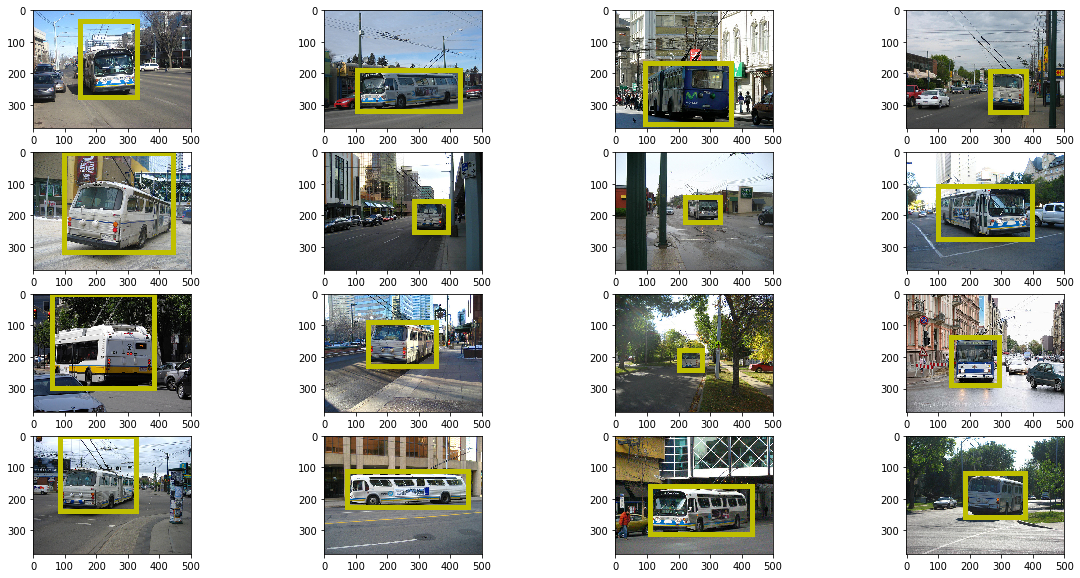

In [6]:
img_class = list(annotations_dict.keys())[0]
print(img_class)
print(synset_dict[img_class])
image_filenames = list(annotations_dict[img_class].keys())
print(len(image_filenames))

fig, axs = plt.subplots(4,4, figsize=(20,10))
axs = axs.flatten()
for i, image_file_id in enumerate(image_filenames[:16]):
    image_file = data_folder+'/train/'+img_class+'/' +image_file_id+'.JPEG'
    image = Image.open(image_file)
    axs[i].imshow(image)
    bounding_box = annotations_dict[img_class][image_file_id]['bounding_boxes'][0]

    rect = patches.Rectangle(bounding_box[:2],bounding_box[2]-bounding_box[0],bounding_box[3]-bounding_box[1],linewidth=5, edgecolor='y',facecolor='none')
    axs[i].add_patch(rect)
plt.show()

In [7]:
idx_2_class = {}
class_2_idx = {}
images_file_list = []
class_list = []

# Armo carpentas con clases

In [19]:
train_folder = 'reduced_dataset/images/train'
val_folder = 'reduced_dataset/images/val'

In [9]:
import os
from shutil import copyfile, rmtree

In [26]:
for class_id in list(class_2_idx.keys()):
    folder_to_create_train = train_folder+'/'+class_id
    folder_to_create_val = val_folder+'/'+class_id
    if (os.path.isdir(folder_to_create_train)):
        rmtree(folder_to_create_train)
    if (os.path.isdir(folder_to_create_val)):
        rmtree(folder_to_create_val)
    os.mkdir(folder_to_create_train)
    os.mkdir(folder_to_create_val)

In [27]:
# Para train
class_list = []
images_file_list = []
for i, (class_id, v) in enumerate(annotations_dict.items()):
    print(i)
    idx_2_class[i] = class_id
    class_2_idx[class_id] = i
    for image_file_id in v:
        class_list.append(i)
        image_file = data_folder+'/train/'+class_id+'/' +image_file_id+'.JPEG'
        images_file_list.append(image_file)
        #print(image_file)
        copyfile(image_file, train_folder+'/'+class_id+'/' +image_file_id+'.JPEG')

0
1
2
3
4
5
6
7
8
9


In [28]:
# Para val
class_list = []
images_file_list = []
for i, (class_id, v) in enumerate(annotations_dict_val.items()):
    print(i)
    idx_2_class[i] = class_id
    class_2_idx[class_id] = i
    for image_file_id in v:
        class_list.append(i)
        image_file = data_folder+'/val/' +image_file_id+'.JPEG'
        images_file_list.append(image_file)
        #print(image_file)
        copyfile(image_file, val_folder+'/'+class_id+'/' +image_file_id+'.JPEG')

0
1
2
3
4
5
6
7
8
9


In [12]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [323]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [788]:
batch_size = 10
train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3089 images belonging to 10 classes.


In [789]:
def GeneratorMultipleOutputs(generator):
    while True:
        data = next(generator)
        #yield (data[0], data[1], np.ones([generator.batch_size, 1]), np.ones([generator.batch_size, 1])) #, 
        yield data

In [790]:
index_to_class_id = {v:k for k, v in train_generator.class_indices.items()}  

In [791]:
index_to_class_name = {v:synset_dict[k] for k, v in train_generator.class_indices.items()}

In [792]:
train_generator.total_batches_seen

0

In [805]:
from  keras.utils import Sequence
class GeneratorMultipleOutputs(Sequence):
    def __init__(self, generator, annotations_dict):
        self.annotations_dict = annotations_dict
        self.generator = generator
    def get_image_object_center(self):
        bboxes = []
        batch_index = self.generator.batch_index
        if self.generator.batch_index == 0:
            batch_index = self.__len__()
        batch_filenames = np.array(self.generator.filenames)[self.generator.index_array][(batch_index-1)*self.generator.batch_size:batch_index*self.generator.batch_size]
        #print(self.generator.batch_index, self.generator.total_batches_seen, len(batch_filenames), batch_index)
        for filename in batch_filenames:
            arr = filename.split('/')
            class_id = arr[0]
            image_idx = arr[1].split('.')[0]
            bboxes.append(self.annotations_dict[class_id][image_idx]['bounding_boxes'][0])
        bboxes = np.array(bboxes)
        centerX = (bboxes[:,0]+(bboxes[:,2]-bboxes[:,0])/2)/self.annotations_dict[class_id][image_idx]['width']
        centerY = (bboxes[:,1]+(bboxes[:,3]-bboxes[:,1])/2)/self.annotations_dict[class_id][image_idx]['height']
        return centerX, centerY
    def __len__(self):
        return int(np.ceil(self.generator.samples / float(self.generator.batch_size)))
    def __getitem__(self, idx):
        data = next(self.generator)
        centerX, centerY = self.get_image_object_center()
        return (data[0], [data[1], centerX, centerY])
    def __next__(self):
        return self.__getitem__(0)
    def __iter__(self):
        return self

In [806]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(train_generator, annotations_dict_train)

In [786]:
while True:
    next(train_generator_multiple_outputs)

38 87 64 38
39 88 64 39
40 89 64 40
41 90 64 41
42 91 64 42
43 92 64 43
44 93 64 44
45 94 64 45
46 95 64 46
47 96 64 47
48 97 64 48
0 98 17 49
1 99 64 1
2 100 64 2
3 101 64 3
4 102 64 4
5 103 64 5
6 104 64 6
7 105 64 7
8 106 64 8
9 107 64 9
10 108 64 10
11 109 64 11
12 110 64 12
13 111 64 13
14 112 64 14
15 113 64 15
16 114 64 16
17 115 64 17
18 116 64 18
19 117 64 19
20 118 64 20
21 119 64 21
22 120 64 22
23 121 64 23
24 122 64 24
25 123 64 25
26 124 64 26
27 125 64 27
28 126 64 28
29 127 64 29
30 128 64 30
31 129 64 31
32 130 64 32
33 131 64 33
34 132 64 34
35 133 64 35
36 134 64 36
37 135 64 37
38 136 64 38
39 137 64 39
40 138 64 40
41 139 64 41
42 140 64 42
43 141 64 43
44 142 64 44
45 143 64 45
46 144 64 46
47 145 64 47
48 146 64 48
0 147 17 49
1 148 64 1
2 149 64 2
3 150 64 3
4 151 64 4
5 152 64 5
6 153 64 6
7 154 64 7
8 155 64 8
9 156 64 9


TypeError: float() argument must be a string or a number, not 'JpegImageFile'

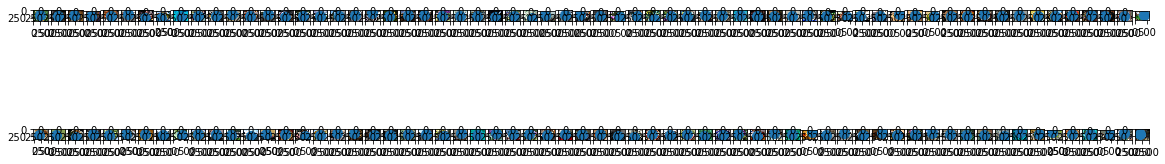

In [772]:
i = 0
N = 2
f, ax = plt.subplots(N, train_generator.batch_size, figsize=(20, 2*N))
for batch in train_generator_multiple_outputs:
    #title = list(map(index_to_class_name.get, np.argmax(batch[1][0], axis = 1)))
    centerX, centerY = batch[1][1:]
    for j, bat in enumerate(batch[0]):
        ax[i, j].imshow(bat)
        ax[i, j].scatter(centerX[j]*500, centerY[j]*375, s= 100)
    i += 1
    if i >= N:
        break
plt.show()

In [807]:
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3089 images belonging to 10 classes.


In [808]:
batch_size = 64
val_generator = val_datagen.flow_from_directory(
    directory=val_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 237 images belonging to 10 classes.


In [809]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(train_generator, annotations_dict_train)
val_generator_multiple_outputs = GeneratorMultipleOutputs(val_generator, annotations_dict_val)

In [810]:
def get_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2)):
    conv = Conv2D(filters, filter_size)(x)
    BN = BatchNormalization()(conv)
    act = Activation('relu')(BN)
    out = MaxPooling2D(pool_size=pool_size)(act)
    # DO1 = Dropout(0.25)(maxPool1)
    return out

In [827]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from keras.constraints import max_norm

def get_simple_model(input_shape=(375, 500, 3)):
    x = Input(shape=(375, 500, 3))
    l1 = get_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2))
    
    l2 = get_layer(l1, filters = 64, filter_size = (3,3), pool_size=(2,2))
    
    l3 = get_layer(l2, filters = 128, filter_size = (3,3), pool_size=(2,2))
    
    l4 = get_layer(l3, filters = 256, filter_size = (3,3), pool_size=(2,2))
    
    l5 = get_layer(l4, filters = 512, filter_size = (3,3), pool_size=(2,2))

    GAP = GlobalAveragePooling2D()(l5)
    #last_layer = Dropout(0.25)(GAP)
    return GAP, x
last_layer, input_layer = get_simple_model()

In [828]:
classes = 10
classification = Dense(classes, activation='softmax', name='category_output')(last_layer) #kernel_constraint=max_norm(2.)
regression_center_x = Dense(1, name='center_x')(last_layer)
regression_center_y = Dense(1, name='center_y')(last_layer)
model = Model(inputs=input_layer, outputs=[classification, regression_center_x, regression_center_y])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_287 (Conv2D)             (None, 373, 498, 32) 896         input_53[0][0]                   
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 373, 498, 32) 128         conv2d_287[0][0]                 
__________________________________________________________________________________________________
activation_227 (Activation)     (None, 373, 498, 32) 0           batch_normalization_115[0][0]    
__________________________________________________________________________________________________
max_poolin

In [829]:
from keras.optimizers import Adam

In [830]:
losses = {"category_output": "categorical_crossentropy", "center_x": "mean_squared_error", "center_y": "mean_squared_error"}
metrics = {"category_output": "accuracy", "center_x": "mae", "center_y": "mae"}
lossWeights = {"category_output": 1.0, "center_x": 10.0,  "center_y": 10.0}

In [831]:
model.compile(loss=losses,
              optimizer=Adam(lr=0.001),
              metrics=metrics,
              loss_weights = lossWeights)

In [ ]:
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=val_generator_multiple_outputs)

Epoch 1/200
49/49 [==============================] - 27s 543ms/step - loss: 9.6274 - category_output_loss: 2.1177 - center_x_loss: 0.2836 - center_y_loss: 0.4674 - category_output_acc: 0.2639 - center_x_mean_absolute_error: 0.2664 - center_y_mean_absolute_error: 0.2881 - val_loss: 2.9830 - val_category_output_loss: 2.5166 - val_center_x_loss: 0.0275 - val_center_y_loss: 0.0192 - val_category_output_acc: 0.2278 - val_center_x_mean_absolute_error: 0.1362 - val_center_y_mean_absolute_error: 0.1145
Epoch 2/200
49/49 [==============================] - 22s 454ms/step - loss: 2.1056 - category_output_loss: 1.9167 - center_x_loss: 0.0094 - center_y_loss: 0.0095 - category_output_acc: 0.3590 - center_x_mean_absolute_error: 0.0715 - center_y_mean_absolute_error: 0.0741 - val_loss: 2.0450 - val_category_output_loss: 1.8297 - val_center_x_loss: 0.0110 - val_center_y_loss: 0.0105 - val_category_output_acc: 0.4135 - val_center_x_mean_absolute_error: 0.0760 - val_center_y_mean_absolute_error: 0.0833


In [141]:
model.evaluate_generator(val_generator)

[0.8494991622393644, 0.7510548550871354]

In [142]:
model.evaluate_generator(train_generator)

[0.3320881910851257, 0.8685658789638101]